In [1]:
import geopandas as gpd
import pandana as pdna
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

%matplotlib inline

In [2]:
#leer fuentes de informacion
parques = pd.read_csv('../carto/parks_point.csv')

# eliminar parques de area menor a 0.5 hectareas o 5000m el estandar de ONU
parques = parques.loc[parques['area'] >=5000,:].copy()

parques = gpd.GeoDataFrame(parques,
                           geometry = gpd.points_from_xy(parques.x, parques.y),
                           crs='EPSG:4326')
parques = parques.to_crs('EPSG:3857')
parques['x'] = parques.geometry.x
parques['y'] = parques.geometry.y

#comunas caba
comunas = gpd.read_file('../carto/CABA_comunas.geojson')
comunas['comuna'] = comunas.COMUNAS.map(lambda c: 'Comuna '+str(int(c)))
comunas = comunas.reindex(columns = ['comuna','geometry'])
comunas = comunas.to_crs('EPSG:3857')

# esquinas nodos
nodes = gpd.read_file('../carto/region_nodes.geojson')
nodes = nodes.to_crs('EPSG:3857')
nodes['x'] = nodes.geometry.x
nodes['y'] = nodes.geometry.y
nodes.index = pd.to_numeric(nodes.osmid)
nodes.drop('osmid',axis=1,inplace=True)
nodes = nodes.loc[~nodes.index.duplicated(keep='first')]

# calles arcos
edges = gpd.read_file('../carto/region_edges.geojson')
edges = edges.to_crs('EPSG:3857')
edges['from'] = pd.to_numeric(edges['from'])
edges['to'] = pd.to_numeric(edges['to'])
edges = edges.loc[~edges.index.duplicated(keep='first')]

In [3]:
parques.shape

(19863, 7)

In [4]:
# configuar la red en pandana
net=pdna.Network(nodes["x"], nodes["y"], edges["from"], edges["to"],edges[["length"]])
net.precompute(2000)

In [5]:
# asignar nodo en la red de pandana
parques["osmid"] = net.get_node_ids(parques.x, parques.y)

In [6]:
# configurar los parques como puntos de interes
net.set_pois("parques", 2000, 3, parques.x, parques.y)


In [7]:
#calcular distancias a parques
%time distancias_esquina_parques = net.nearest_pois(2000, "parques", num_pois=1)

CPU times: user 5.68 s, sys: 23.9 ms, total: 5.71 s
Wall time: 1.72 s


In [8]:
# asignar a cada esquina su distancia al parque mas cercano
nodes = nodes.merge(distancias_esquina_parques,how='left',on='osmid')
nodes = nodes.rename(columns={1:'distancia_parques'})

In [9]:
# crear una variable para agregar 
net.set(parques["osmid"], variable=parques['area'], name="parques_area")


In [10]:
agregado_linear = net.aggregate(300, type="sum", decay="linear", name="parques_area")
nodes['agregado_linear'] = agregado_linear

In [11]:
nodes.head()

,y,x,partido,highway,ref,geometry,distancia_parques,agregado_linear
osmid,,,,,,,,
631513110,-4.151063e+06,-6.529359e+06,Cañuelas,None,None,POINT (-6529359.473 -4151062.759),631.857971,0.000000
631513111,-4.150557e+06,-6.528565e+06,Cañuelas,None,None,POINT (-6528565.498 -4150557.168),262.148010,1848.824129
631513112,-4.149595e+06,-6.529170e+06,Cañuelas,None,None,POINT (-6529169.695 -4149595.334),200.421005,7521.996193
678977566,-4.178512e+06,-6.538353e+06,Cañuelas,None,None,POINT (-6538353.275 -4178511.716),2000.000000,0.000000
678977570,-4.178872e+06,-6.538338e+06,Cañuelas,None,None,POINT (-6538338.225 -4178871.627),2000.000000,0.000000


In [12]:
# calcular tablas de estadisticos resumen
tabla_por_partido_mean = nodes.reindex(columns = ['distancia_parques','agregado_linear','partido'])\
    .groupby('partido').mean()\
    .sort_values('distancia_parques',ascending=True)

tabla_por_partido_median = nodes.reindex(columns = ['distancia_parques','agregado_linear','partido'])\
    .groupby('partido').median()\
    .sort_values('distancia_parques',ascending=True)

tabla_por_partido_p75 = nodes.reindex(columns = ['distancia_parques','agregado_linear','partido'])\
    .groupby('partido').quantile(.75)\
    .sort_values('distancia_parques',ascending=True)

tabla_por_partido_mean.head()

,distancia_parques,agregado_linear
partido,,
CABA,470.370881,116497.838034
Morón,508.765507,18583.308011
Avellaneda,552.544487,16014.339088
Tres de Febrero,565.396816,8045.219066
San Fernando,602.430139,17051.314092


In [13]:
# crear orden de los partidos para los graficos
order_distancia_partido = tabla_por_partido_mean.sort_values('distancia_parques').index
order_agregado_partido = tabla_por_partido_median.sort_values('agregado_linear',ascending=False).index
order_agregado_partido_75 = tabla_por_partido_p75.sort_values('agregado_linear',ascending=False).index

## Analisis por partido

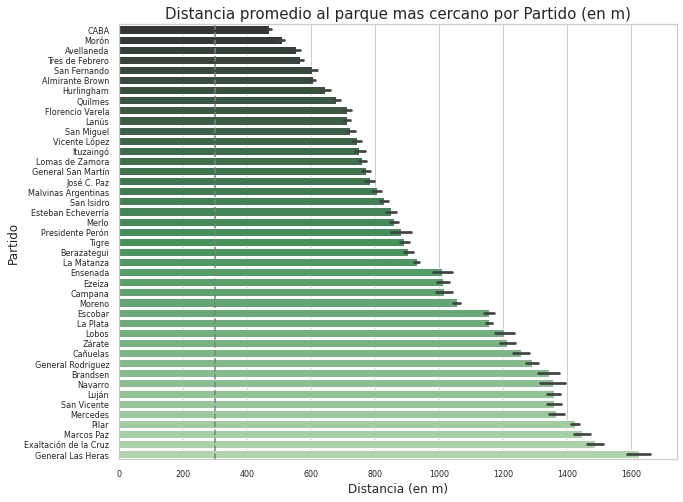

In [14]:
f,ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(x="distancia_parques", y="partido", data=nodes,
                 palette="Greens_d",
                 order = order_distancia_partido)

ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=6)

ax.set_title('Distancia promedio al parque mas cercano por Partido (en m)', fontsize=15)
ax.set_xlabel('Distancia (en m)', fontsize=12)
ax.set_ylabel('Partido', fontsize=12)
ax.axvline(300,linestyle='--',color='grey')
f.savefig('../img/distancia_por_partido.png')

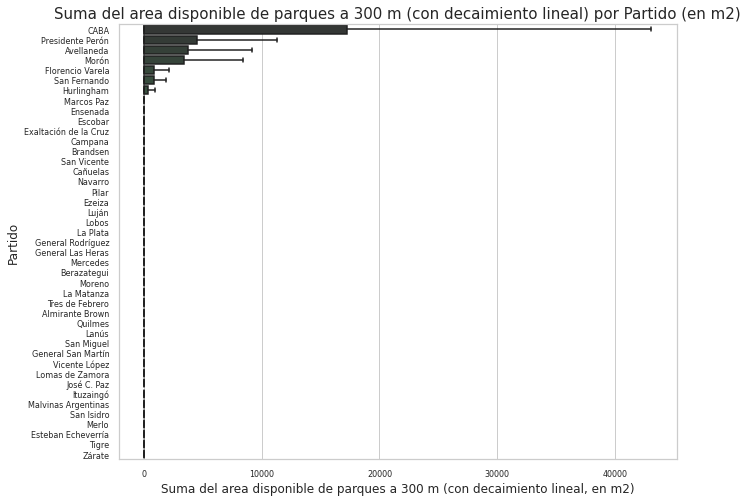

In [15]:
f,ax = plt.subplots(figsize=(10,8))
ax = sns.boxplot(x="agregado_linear", y="partido", data=nodes,
                 palette="Greens_d",
                 showfliers=False,
                 #showmeans=True,
                 order = order_agregado_partido_75)

ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=6)

ax.set_title('Suma del area disponible de parques a 300 m (con decaimiento lineal) por Partido (en m2)', fontsize=15)
ax.set_xlabel('Suma del area disponible de parques a 300 m (con decaimiento lineal, en m2)', fontsize=12)
ax.set_ylabel('Partido', fontsize=12)
f.savefig('../img/area_por_partido.png')

In [16]:
nodes_caba = nodes.loc[nodes.partido=='CABA'].copy()
nodes_caba = gpd.sjoin(nodes_caba,comunas,how='left')
nodes_caba = nodes_caba.loc[nodes_caba.comuna.notnull(),:]

In [17]:
tabla_por_comuna_mean = nodes_caba.reindex(columns = ['distancia_parques','agregado_linear','comuna'])\
    .groupby('comuna').mean()\
    .sort_values('agregado_linear',ascending=False)

tabla_por_comuna_median = nodes_caba.reindex(columns = ['distancia_parques','agregado_linear','comuna'])\
    .groupby('comuna').median()\
    .sort_values('agregado_linear',ascending=False)

tabla_por_comuna_75q = nodes_caba.reindex(columns = ['distancia_parques','agregado_linear','comuna'])\
    .groupby('comuna').quantile(.75)\
    .sort_values('agregado_linear',ascending=False)

order_distancia_comuna = tabla_por_comuna_mean.sort_values('distancia_parques').index
order_agregado_comuna = tabla_por_comuna_median.sort_values('agregado_linear',ascending=False).index
order_agregado_comuna_75 = tabla_por_comuna_75q.sort_values('agregado_linear',ascending=False).index

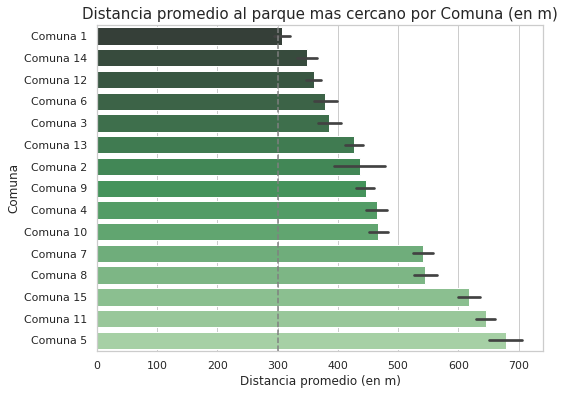

In [18]:
f,ax = plt.subplots(figsize=(8,6))
ax = sns.barplot(x="distancia_parques", y="comuna", data=nodes_caba,
                 palette="Greens_d",
                 order=order_distancia_comuna
                )

ax.set_title('Distancia promedio al parque mas cercano por Comuna (en m)', fontsize=15)
ax.set_xlabel('Distancia promedio (en m)', fontsize=12)
ax.set_ylabel('Comuna', fontsize=12)
ax.axvline(300,linestyle='--',color='grey')
f.savefig('../img/distancia_por_comuna.png')

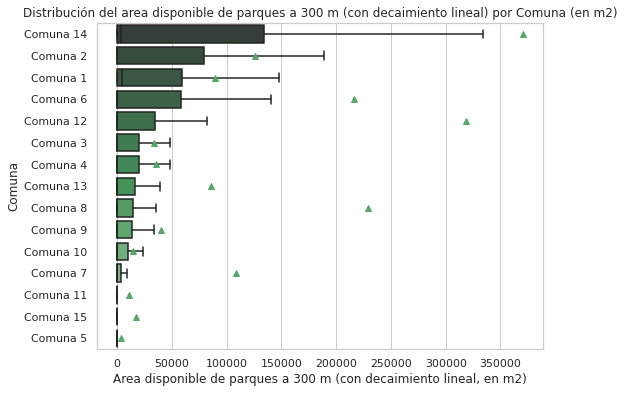

In [19]:
f,ax = plt.subplots(figsize=(8,6))
ax = sns.boxplot(x="agregado_linear", y="comuna", data=nodes_caba,
                 showfliers=False,
                 palette="Greens_d",
                 showmeans=True,
                 order=order_agregado_comuna_75
                )

ax.set_title('Distribución del area disponible de parques a 300 m (con decaimiento lineal) por Comuna (en m2)')
ax.set_xlabel('Area disponible de parques a 300 m (con decaimiento lineal, en m2)')
ax.set_ylabel('Comuna')
f.savefig('../img/area_por_comuna.png')

In [20]:
nodes.to_file('../carto/nodos_con_data.geojson',driver='GeoJSON')